In [1]:
import random
from PIL import Image
import numpy as np

import torch
from  torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")# if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [3]:
total = 3683
name = []
labels = {}
for i in range(total):
    item = "KR_k-" + str(i/1000) + ".png"
    name.append(item)
    labelsi = {name[i] : name[i][5:-4]}
    labels.update(labelsi)

random.shuffle(name)
partition = {'train': name[:int(len(name)*0.8)], 'validation': name[int(len(name)*0.8):int(len(name)*0.9)], 'test': name[int(len(name)*0.9):]}

In [4]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)


  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        transform = transforms.Compose([transforms.PILToTensor()])
        X = transform(Image.open('./Dados_2/' + ID).resize((100, 100)))/255.
        y = self.labels[ID]

        return X.to(device), float(y)


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

https://www.youtube.com/watch?v=NVxCKdp0NhQ

In [8]:
# Parameters
params = {'batch_size': 32,
          'shuffle': True}
max_epochs = 100

# Generators
training_set = Dataset(partition['train'], labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [9]:
class KR(nn.Module):
    def __init__(self):
        super(KR, self).__init__()
        self.conv = nn.Sequential(

            nn.Conv2d(4, 8, 3, padding=1), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2), #50

            nn.Conv2d(8, 16, 3, padding=1), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2), #25

            nn.Conv2d(16, 32, 3, padding=1), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2)) #12
        
        self.linear = nn.Sequential(

            nn.Linear(32*12*12,1024),
            nn.LeakyReLU(0.1),

            nn.Linear(1024,512),
            nn.LeakyReLU(0.1),

            nn.Linear(512,128),
            nn.LeakyReLU(0.1),

            nn.Linear(128,1),
            nn.LeakyReLU(0.1),

            nn.Linear(1,1),
            nn.LeakyReLU(0.1))
    
    def forward(self, x):
        h = self.conv(x)
        #r = torch.reshape(h, (-1,))
        h = h.view(-1, 32*12*12)
        h = self.linear(h)
        return h

In [10]:
kr = KR()
kr.to(device)

KR(
  (conv): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.1)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=4608, out_features=1024, bias=True)
    (1): LeakyReLU(nega

In [11]:
optimizer = torch.optim.Adam(kr.parameters(), lr=2.5E-3)
loss = torch.nn.L1Loss()
max_epochs = 300

In [12]:
# Loop over epochs
idx = 0
batch_size = 16
losses = []
loss_per_epoch = []
val_loss_per_epoch = []
val_losses = []

for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        idx += 1
        # take a batch
        local_batch.to(device)
        local_labels = torch.Tensor(list(local_labels)).to(device)
        optimizer.zero_grad()
        # forward pass
        input = kr(local_batch).view(-1)
        output = torch.nn.functional.mse_loss(input, local_labels)
        # backward pass
        output.backward()
        # update weights
        optimizer.step()

        losses.append(float(output))

        #if idx%100 == 0:
    loss_per_epoch.append(float(output))

    # Validation
    with torch.set_grad_enabled(False):
        for vlocal_batch, vlocal_labels in validation_generator:
            vlocal_batch.to(device)
            vlocal_labels = torch.Tensor(list(vlocal_labels)).to(device)

            vinput = kr(vlocal_batch).view(-1)

            voutput = torch.nn.functional.mse_loss(vinput, vlocal_labels)


            val_losses.append(float(voutput))
    
    val_loss_per_epoch.append(float(voutput))
    
    print("\tEpoch", epoch +1, "\tAverage Loss: ", output.tolist()/(batch_size), "\tValidation Loss: ", voutput.tolist()/(batch_size))

print('Finished Training')

	Epoch 1 	Average Loss:  0.00636912789195776 	Validation Loss:  0.0048409728333354
	Epoch 2 	Average Loss:  0.0027389805763959885 	Validation Loss:  0.0021748810540884733
	Epoch 3 	Average Loss:  0.0011746548116207123 	Validation Loss:  0.002495016437023878
	Epoch 4 	Average Loss:  0.0019721665885299444 	Validation Loss:  0.0006509008817374706
	Epoch 5 	Average Loss:  0.00020454831246752292 	Validation Loss:  0.0016996460035443306
	Epoch 6 	Average Loss:  0.0016011984553188086 	Validation Loss:  0.010073613375425339
	Epoch 7 	Average Loss:  0.0026326836086809635 	Validation Loss:  0.0010163160040974617
	Epoch 8 	Average Loss:  2.641102037159726e-05 	Validation Loss:  0.004394525662064552
	Epoch 9 	Average Loss:  0.00042789155850186944 	Validation Loss:  0.00042082276195287704
	Epoch 10 	Average Loss:  0.00043832050869241357 	Validation Loss:  0.0007411782280541956
	Epoch 11 	Average Loss:  0.0003477355057839304 	Validation Loss:  0.003068161429837346
	Epoch 12 	Average Loss:  0.0008441

KeyboardInterrupt: 

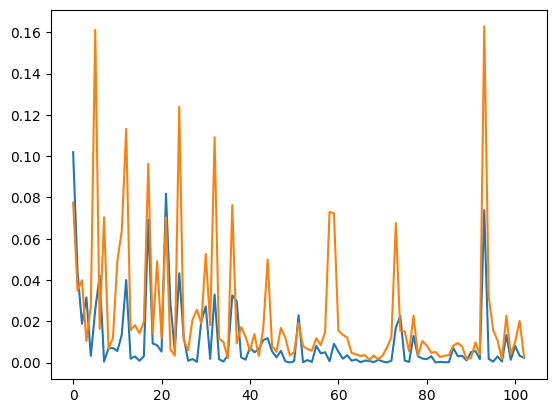

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(len(loss_per_epoch)), loss_per_epoch, color='tab:blue', label = 'Train')
ax.plot(np.arange(len(val_loss_per_epoch)), val_loss_per_epoch, color='tab:orange', label = "Val")
plt.show()

In [14]:
test_set = Dataset(partition['validation'], labels)
test_generator = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle= True)

for i in range(10):
    tlocal_batch, tlocal_labels = next(iter(test_generator))

    pred = kr(tlocal_batch)
    print(pred) #prediction
    print(tlocal_labels) #true
    print('------------')



tensor([[0.3966]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([0.3390], dtype=torch.float64)
------------
tensor([[1.6081]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([1.5550], dtype=torch.float64)
------------
tensor([[2.9394]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([2.9800], dtype=torch.float64)
------------
tensor([[0.4158]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([0.3440], dtype=torch.float64)
------------
tensor([[1.0656]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([1.1610], dtype=torch.float64)
------------
tensor([[3.2365]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([3.2550], dtype=torch.float64)
------------
tensor([[1.6081]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([1.5550], dtype=torch.float64)
------------
tensor([[2.7884]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([2.8730], dtype=torch.float64)
------------
tensor([[3.2104]], device='cuda:0', grad_fn=<LeakyReluBackward0>

In [15]:
test_set = Dataset(partition['test'], labels)
a = 35
test_generator = torch.utils.data.DataLoader(test_set[a], batch_size = 1)

tlocal_batch, tlocal_labels = test_generator

pred = kr(tlocal_batch)
print(pred)
print(tlocal_labels)
print('------------')


tensor([[3.3612]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([3.4300], dtype=torch.float64)
------------
